Using OCP to enumerate adsorbates on catalyst surfaces
======================================================

In the previous example, we constructed slab models of adsorbates on desired sites. Here we leverage code to automate this process. The goal in this section is to generate candidate structures, compute energetics, and then filter out the most relevant ones.

In [1]:
from ocpmodels.common.relaxation.ase_utils import OCPCalculator
import ase.io
from ase.optimize import BFGS
import sys
from scipy.stats import linregress
import pickle
import matplotlib.pyplot as plt
import time

from ocdata.core import Adsorbate, AdsorbateSlabConfig, Bulk, Slab
import os
from glob import glob
import pandas as pd
from ocdata.utils import DetectTrajAnomaly

In [2]:
%run ../ocp-tutorial.ipynb

checkpoint = get_checkpoint('GemNet-OC-Large All+MD')
checkpoint

# Introduction

We will reproduce Fig 6b from the following paper: Zhou, Jing, et al. "Enhanced Catalytic Activity of Bimetallic Ordered Catalysts for Nitrogen Reduction Reaction by Perturbation of Scaling Relations." ACS Catalysis 134 (2023): 2190-2201 (https://doi.org/10.1021/acscatal.2c05877).

The gist of this figure is a correlation between H* and NNH* adsorbates across many different alloy surfaces. Then, they identify a dividing line between these that separates surfaces known for HER and those known for NRR.

To do this, we will enumerate adsorbate-slab configurations and run ML relaxations on them to find the lowest energy configuration. We will assess parity between the model predicted values and those reported in the paper. Finally we will make the figure and assess separability of the NRR favored and HER favored domains.

# Enumerate the adsorbate-slab configurations to run relaxations on

Be sure to set the path in `ocdata/configs/paths.py` to point to the correct place or pass the paths as an argument. The database pickles can be found in `ocdata/databases/pkls`. We will show one explicitly here as an example and then run all of them in an automated fashion for brevity.

In [3]:
import ocdata
from pathlib import Path
db = Path(ocdata.__file__).parent / Path('databases/pkls/adsorbates.pkl')
db

PosixPath('/home/jovyan/shared-scratch/jkitchin/ocdata/ocdata/databases/pkls/adsorbates.pkl')

## Work out a single example

We load one bulk id, create a bulk reference structure from it, then generate the surfaces we want to compute.

In [4]:
bulk_src_id = "oqmd-343039"
adsorbate_smiles_nnh = "*N*NH"
adsorbate_smiles_h = "*H"

bulk = Bulk(bulk_src_id_from_db = bulk_src_id, bulk_db_path="NRR_example_bulks.pkl")
adsorbate_H = Adsorbate(adsorbate_smiles_from_db = adsorbate_smiles_h, adsorbate_db_path=db)
adsorbate_NNH = Adsorbate(adsorbate_smiles_from_db = adsorbate_smiles_nnh, adsorbate_db_path=db)
slab = Slab.from_bulk_get_specific_millers(bulk= bulk, specific_millers = (1, 1, 1))
slab

[Slab: (Ag36Pd12, (1, 1, 1), 0.16666666666666657, True)]

We now need to generate potential placements. We use two kinds of guesses, a heuristic and a random approach. This cell generates 13 potential adsorption geometries.

In [5]:
# Perform heuristic placements
heuristic_adslabs = AdsorbateSlabConfig(slab[0], adsorbate_H, mode="heuristic")

# Perform random placements
# (for AdsorbML we use `num_sites = 100` but we will use 4 for brevity here)
random_adslabs = AdsorbateSlabConfig(slab[0], adsorbate_H, mode="random_site_heuristic_placement", num_sites=4)

adslabs = [*heuristic_adslabs.atoms_list, *random_adslabs.atoms_list]
len(adslabs)

13

Let's see what we are looking at. It is a little tricky to see the tiny H atom in these figures, but with some inspection you can see there are ontop, bridge, and hollow sites in different places. This is not an exhaustive search; you can increase the number of random placements to check more possibilities. The main idea here is to *increase* the probability you find the most relevant sites.

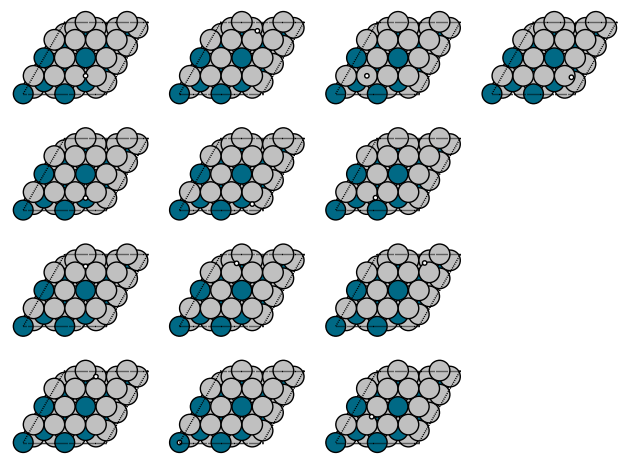

In [6]:
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms

fig, axs = plt.subplots(4, 4)

for i, slab in enumerate(adslabs):
    plot_atoms(slab, axs[i % 4, i // 4]);
    axs[i % 4, i // 4].set_axis_off()
    
for i in range(16):
    axs[i % 4, i // 4].set_axis_off()

plt.tight_layout()   

### Run an ML relaxation

We will use an ASE compatible calculator to run these.

Running the model with BFGS prints at each relaxation step which is a lot to print. So we will just run one to demonstrate what happens on each iteration.

In [7]:
os.makedirs(f"data/{bulk_src_id}_{adsorbate_smiles_h}", exist_ok=True)

# Define the calculator
calc = OCPCalculator(checkpoint=checkpoint, cpu=False)   # if you have a GPU
# calc = OCPCalculator(checkpoint=checkpoint_path, cpu=True)  # If you have CPU only

amp: true
cmd:
  checkpoint_dir: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/NRR/checkpoints/2023-07-20-12-50-08
  commit: cae7b96
  identifier: ''
  logs_dir: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/NRR/logs/tensorboard/2023-07-20-12-50-08
  print_every: 100
  results_dir: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/NRR/results/2023-07-20-12-50-08
  seed: null
  timestamp_id: 2023-07-20-12-50-08
dataset: null
gpus: 1
logger: tensorboard
model: gemnet_oc
model_attributes:
  activation: silu
  atom_edge_interaction: true
  atom_interaction: true
  cbf:
    name: spherical_harmonics
  cutoff: 12.0
  cutoff_aeaint: 12.0
  cutoff_aint: 12.0
  cutoff_qint: 12.0
  direct_forces: true
  edge_atom_interaction: true
  emb_size_aint_in: 64
  emb_size_aint_out: 64
  emb_size_atom: 256
  emb_size_cbf: 16
  emb_size_edge: 1024
  emb_size_quad_in: 64
  emb_size_quad_out: 32
  emb_size_rbf: 32
  emb_size_sbf: 64
  emb_size_trip_in: 64
  emb_size_trip_o

Now we setup and run the relaxation.

In [8]:
t0 = time.time()
os.makedirs(f"data/{bulk_src_id}_H", exist_ok=True)
adslab = adslabs[0]
adslab.calc = calc
opt = BFGS(adslab, trajectory=f"data/{bulk_src_id}_H/test.traj")
opt.run(fmax=0.05, steps=100)

print(f'Elapsed time {time.time() - t0:1.1f} seconds')

      Step     Time          Energy         fmax
BFGS:    0 12:49:59        0.655569        0.4151
BFGS:    1 12:49:59        0.627050        0.3942
BFGS:    2 12:49:59        0.540020        0.2654
BFGS:    3 12:49:59        0.539154        0.2619
BFGS:    4 12:49:59        0.520989        0.2360
BFGS:    5 12:49:59        0.519339        0.2461
BFGS:    6 12:49:59        0.511696        0.2962
BFGS:    7 12:49:59        0.506129        0.4065
BFGS:    8 12:49:59        0.487648        0.6603
BFGS:    9 12:49:59        0.454749        0.8966
BFGS:   10 12:49:59        0.412168        1.0472
BFGS:   11 12:50:00        0.390264        1.0580
BFGS:   12 12:50:00        0.360911        0.9312
BFGS:   13 12:50:00        0.338499        0.9446
BFGS:   14 12:50:00        0.264450        0.9969
BFGS:   15 12:50:00        0.212884        0.8842
BFGS:   16 12:50:00        0.178773        0.9724
BFGS:   17 12:50:00        0.158545        0.8156
BFGS:   18 12:50:00        0.146907        0.7196
B

With a GPU this runs pretty quickly. It is much slower on a CPU.

# Run all the systems

In principle you can run all the systems now. It takes about an hour though, and we leave that for a later exercise if you want. For now we will run the first two, and for later analysis we provide a results file of all the runs. Let's read in our reference file and take a look at what is in it.

In [9]:
with open("NRR_example_bulks.pkl", "rb") as f:
    bulks = pickle.load(f)
    
bulks

[{'atoms': Atoms(symbols='CuPd3', pbc=True, cell=[3.91276645, 3.91276645, 3.91276645], calculator=SinglePointDFTCalculator(...)),
  'src_id': 'oqmd-349719'},
 {'atoms': Atoms(symbols='Pd3Ag', pbc=True, cell=[4.02885979, 4.02885979, 4.02885979], calculator=SinglePointDFTCalculator(...)),
  'src_id': 'oqmd-345911'},
 {'atoms': Atoms(symbols='ScPd3', pbc=True, cell=[4.04684963, 4.04684963, 4.04684963], initial_charges=..., initial_magmoms=..., momenta=..., tags=..., calculator=SinglePointCalculator(...)),
  'src_id': 'mp-2677'},
 {'atoms': Atoms(symbols='Mo3Pd', pbc=True, cell=[3.96898192, 3.96898192, 3.96898192], initial_charges=..., initial_magmoms=..., momenta=..., tags=..., calculator=SinglePointCalculator(...)),
  'src_id': 'mp-1186014'},
 {'atoms': Atoms(symbols='Ag3Pd', pbc=True, cell=[4.14093081, 4.14093081, 4.14093081], calculator=SinglePointCalculator(...)),
  'src_id': 'oqmd-343039'},
 {'src_id': 'oqmd-348629',
  'atoms': Atoms(symbols='Ag3Cu', pbc=True, cell=[4.09439099, 4.094

We have 19 bulk materials we will consider. Next we extract the `src-id` for each one.

In [10]:
bulk_ids = [row['src_id'] for row in bulks]

In theory you would run all of these, but it takes about an hour with a GPU. We provide the relaxation logs and trajectories in the repo for the next step.

These steps are embarrassingly parallel, and can be launched that way to speed things up. The only thing you need to watch is that you don't exceed the available RAM, which will cause the Jupyter kernel to crash.

The goal here is to relax each candidate adsorption geometry and save the results in a trajectory file we will analyze later. Each trajectory file will have the geometry and final energy of the relaxed structure. 

It is somewhat time consuming to run this, so in this cell we only run one example.

In [ ]:
import time
from tqdm import tqdm
tinit = time.time()

for bulk_src_id in tqdm(bulk_ids[1:2]): 
    # Enumerate slabs and establish adsorbates
    bulk = Bulk(bulk_src_id_from_db=bulk_src_id, bulk_db_path="NRR_example_bulks.pkl")
    slab = Slab.from_bulk_get_specific_millers(bulk= bulk, specific_millers=(1, 1, 1))

    # Perform heuristic placements
    heuristic_adslabs_H = AdsorbateSlabConfig(slab[0], adsorbate_H, mode="heuristic")
    heuristic_adslabs_NNH = AdsorbateSlabConfig(slab[0], adsorbate_NNH, mode="heuristic")

    #Run relaxations
    os.makedirs(f"data/{bulk_src_id}_H", exist_ok=True)
    os.makedirs(f"data/{bulk_src_id}_NNH", exist_ok=True)

    print(f'{len(heuristic_adslabs_H.atoms_list)} H slabs to compute for {bulk_src_id}')
    print(f'{len(heuristic_adslabs_NNH.atoms_list)} NNH slabs to compute for {bulk_src_id}')

    # Set up the calculator
    for idx, adslab in enumerate(heuristic_adslabs_H.atoms_list):
        t0 = time.time()
        adslab.calc = calc
        print(f'Running data/{bulk_src_id}_H/{idx}')
        opt = BFGS(adslab, trajectory=f"data/{bulk_src_id}_H/{idx}.traj", logfile=f"data/{bulk_src_id}_H/{idx}.log")
        opt.run(fmax=0.05, steps=20)
        print(f'  Elapsed time: {time.time() - t0:1.1f} seconds for data/{bulk_src_id}_H/{idx}')
        
    for idx, adslab in enumerate(heuristic_adslabs_NNH.atoms_list):
        t0 = time.time()
        adslab.calc = calc
        print(f'Running data/{bulk_src_id}_NNH/{idx}')
        opt = BFGS(adslab, trajectory=f"data/{bulk_src_id}_NNH/{idx}.traj", logfile=f"data/{bulk_src_id}_NNH/{idx}.log")
        opt.run(fmax=0.05, steps=50)
        print(f'  Elapsed time: {time.time() - t0:1.1f} seconds for data/{bulk_src_id}_NNH/{idx}')

print(f'Elapsed time: {time.time() - tinit:1.1f} seconds')

This cell runs all the examples. I don't recommend you do this during the workshop. Instead, we have saved the results for the subsequent analyses so you can skip this one.

In [11]:
import time
from tqdm import tqdm
tinit = time.time()

for bulk_src_id in tqdm(bulk_ids): 
    # Enumerate slabs and establish adsorbates
    bulk = Bulk(bulk_src_id_from_db=bulk_src_id, bulk_db_path="NRR_example_bulks.pkl")
    slab = Slab.from_bulk_get_specific_millers(bulk= bulk, specific_millers=(1, 1, 1))

    # Perform heuristic placements
    heuristic_adslabs_H = AdsorbateSlabConfig(slab[0], adsorbate_H, mode="heuristic")
    heuristic_adslabs_NNH = AdsorbateSlabConfig(slab[0], adsorbate_NNH, mode="heuristic")

    #Run relaxations
    os.makedirs(f"data/{bulk_src_id}_H", exist_ok=True)
    os.makedirs(f"data/{bulk_src_id}_NNH", exist_ok=True)

    print(f'{len(heuristic_adslabs_H.atoms_list)} H slabs to compute for {bulk_src_id}')
    print(f'{len(heuristic_adslabs_NNH.atoms_list)} NNH slabs to compute for {bulk_src_id}')

    # Set up the calculator
    for idx, adslab in enumerate(heuristic_adslabs_H.atoms_list):
        t0 = time.time()
        adslab.calc = calc
        print(f'Running data/{bulk_src_id}_H/{idx}')
        opt = BFGS(adslab, trajectory=f"data/{bulk_src_id}_H/{idx}.traj", logfile=f"data/{bulk_src_id}_H/{idx}.log")
        opt.run(fmax=0.05, steps=20)
        print(f'  Elapsed time: {time.time() - t0:1.1f} seconds for data/{bulk_src_id}_H/{idx}')
        
    for idx, adslab in enumerate(heuristic_adslabs_NNH.atoms_list):
        t0 = time.time()
        adslab.calc = calc
        print(f'Running data/{bulk_src_id}_NNH/{idx}')
        opt = BFGS(adslab, trajectory=f"data/{bulk_src_id}_NNH/{idx}.traj", logfile=f"data/{bulk_src_id}_NNH/{idx}.log")
        opt.run(fmax=0.05, steps=50)
        print(f'  Elapsed time: {time.time() - t0:1.1f} seconds for data/{bulk_src_id}_NNH/{idx}')

print(f'Elapsed time: {time.time() - tinit:1.1f} seconds')

  0%|          | 0/19 [00:00<?, ?it/s]

9 H slabs to compute for oqmd-349719
9 NNH slabs to compute for oqmd-349719
Running data/oqmd-349719_H/0
  Elapsed time: 0.7 seconds for data/oqmd-349719_H/0
Running data/oqmd-349719_H/1
  Elapsed time: 1.3 seconds for data/oqmd-349719_H/1
Running data/oqmd-349719_H/2
  Elapsed time: 2.3 seconds for data/oqmd-349719_H/2
Running data/oqmd-349719_H/3
  Elapsed time: 1.6 seconds for data/oqmd-349719_H/3
Running data/oqmd-349719_H/4
  Elapsed time: 0.6 seconds for data/oqmd-349719_H/4
Running data/oqmd-349719_H/5
  Elapsed time: 0.5 seconds for data/oqmd-349719_H/5
Running data/oqmd-349719_H/6
  Elapsed time: 1.1 seconds for data/oqmd-349719_H/6
Running data/oqmd-349719_H/7
  Elapsed time: 0.9 seconds for data/oqmd-349719_H/7
Running data/oqmd-349719_H/8
  Elapsed time: 0.6 seconds for data/oqmd-349719_H/8
Running data/oqmd-349719_NNH/0
  Elapsed time: 5.6 seconds for data/oqmd-349719_NNH/0
Running data/oqmd-349719_NNH/1
  Elapsed time: 5.6 seconds for data/oqmd-349719_NNH/1
Running data/o

  5%|▌         | 1/19 [01:00<18:17, 60.99s/it]

  Elapsed time: 5.7 seconds for data/oqmd-349719_NNH/8
9 H slabs to compute for oqmd-345911
9 NNH slabs to compute for oqmd-345911
Running data/oqmd-345911_H/0
  Elapsed time: 2.3 seconds for data/oqmd-345911_H/0
Running data/oqmd-345911_H/1
  Elapsed time: 0.9 seconds for data/oqmd-345911_H/1
Running data/oqmd-345911_H/2
  Elapsed time: 2.2 seconds for data/oqmd-345911_H/2
Running data/oqmd-345911_H/3
  Elapsed time: 1.3 seconds for data/oqmd-345911_H/3
Running data/oqmd-345911_H/4
  Elapsed time: 1.3 seconds for data/oqmd-345911_H/4
Running data/oqmd-345911_H/5
  Elapsed time: 0.6 seconds for data/oqmd-345911_H/5
Running data/oqmd-345911_H/6
  Elapsed time: 1.7 seconds for data/oqmd-345911_H/6
Running data/oqmd-345911_H/7
  Elapsed time: 1.6 seconds for data/oqmd-345911_H/7
Running data/oqmd-345911_H/8
  Elapsed time: 0.5 seconds for data/oqmd-345911_H/8
Running data/oqmd-345911_NNH/0
  Elapsed time: 4.9 seconds for data/oqmd-345911_NNH/0
Running data/oqmd-345911_NNH/1
  Elapsed time

 11%|█         | 2/19 [02:01<17:10, 60.60s/it]

  Elapsed time: 5.6 seconds for data/oqmd-345911_NNH/8
9 H slabs to compute for mp-2677
9 NNH slabs to compute for mp-2677
Running data/mp-2677_H/0
  Elapsed time: 0.9 seconds for data/mp-2677_H/0
Running data/mp-2677_H/1
  Elapsed time: 1.3 seconds for data/mp-2677_H/1
Running data/mp-2677_H/2
  Elapsed time: 0.5 seconds for data/mp-2677_H/2
Running data/mp-2677_H/3
  Elapsed time: 1.9 seconds for data/mp-2677_H/3
Running data/mp-2677_H/4
  Elapsed time: 1.9 seconds for data/mp-2677_H/4
Running data/mp-2677_H/5
  Elapsed time: 1.3 seconds for data/mp-2677_H/5
Running data/mp-2677_H/6
  Elapsed time: 0.7 seconds for data/mp-2677_H/6
Running data/mp-2677_H/7
  Elapsed time: 1.5 seconds for data/mp-2677_H/7
Running data/mp-2677_H/8
  Elapsed time: 1.9 seconds for data/mp-2677_H/8
Running data/mp-2677_NNH/0
  Elapsed time: 4.9 seconds for data/mp-2677_NNH/0
Running data/mp-2677_NNH/1
  Elapsed time: 4.9 seconds for data/mp-2677_NNH/1
Running data/mp-2677_NNH/2
  Elapsed time: 4.7 seconds 

 16%|█▌        | 3/19 [02:53<15:04, 56.56s/it]

  Elapsed time: 4.7 seconds for data/mp-2677_NNH/8
9 H slabs to compute for mp-1186014
9 NNH slabs to compute for mp-1186014
Running data/mp-1186014_H/0
  Elapsed time: 2.3 seconds for data/mp-1186014_H/0
Running data/mp-1186014_H/1
  Elapsed time: 1.3 seconds for data/mp-1186014_H/1
Running data/mp-1186014_H/2
  Elapsed time: 1.1 seconds for data/mp-1186014_H/2
Running data/mp-1186014_H/3
  Elapsed time: 2.3 seconds for data/mp-1186014_H/3
Running data/mp-1186014_H/4
  Elapsed time: 0.8 seconds for data/mp-1186014_H/4
Running data/mp-1186014_H/5
  Elapsed time: 1.1 seconds for data/mp-1186014_H/5
Running data/mp-1186014_H/6
  Elapsed time: 0.9 seconds for data/mp-1186014_H/6
Running data/mp-1186014_H/7
  Elapsed time: 2.2 seconds for data/mp-1186014_H/7
Running data/mp-1186014_H/8
  Elapsed time: 2.3 seconds for data/mp-1186014_H/8
Running data/mp-1186014_NNH/0
  Elapsed time: 5.5 seconds for data/mp-1186014_NNH/0
Running data/mp-1186014_NNH/1
  Elapsed time: 4.7 seconds for data/mp-1

 21%|██        | 4/19 [04:00<15:12, 60.84s/it]

  Elapsed time: 8.5 seconds for data/mp-1186014_NNH/8
9 H slabs to compute for oqmd-343039
9 NNH slabs to compute for oqmd-343039
Running data/oqmd-343039_H/0
  Elapsed time: 1.7 seconds for data/oqmd-343039_H/0
Running data/oqmd-343039_H/1
  Elapsed time: 1.3 seconds for data/oqmd-343039_H/1
Running data/oqmd-343039_H/2
  Elapsed time: 1.9 seconds for data/oqmd-343039_H/2
Running data/oqmd-343039_H/3
  Elapsed time: 1.1 seconds for data/oqmd-343039_H/3
Running data/oqmd-343039_H/4
  Elapsed time: 0.5 seconds for data/oqmd-343039_H/4
Running data/oqmd-343039_H/5
  Elapsed time: 1.2 seconds for data/oqmd-343039_H/5
Running data/oqmd-343039_H/6
  Elapsed time: 2.3 seconds for data/oqmd-343039_H/6
Running data/oqmd-343039_H/7
  Elapsed time: 1.4 seconds for data/oqmd-343039_H/7
Running data/oqmd-343039_H/8
  Elapsed time: 1.1 seconds for data/oqmd-343039_H/8
Running data/oqmd-343039_NNH/0
  Elapsed time: 4.1 seconds for data/oqmd-343039_NNH/0
Running data/oqmd-343039_NNH/1
  Elapsed time:

 26%|██▋       | 5/19 [04:55<13:43, 58.80s/it]

  Elapsed time: 5.4 seconds for data/oqmd-343039_NNH/8
9 H slabs to compute for oqmd-348629
9 NNH slabs to compute for oqmd-348629
Running data/oqmd-348629_H/0
  Elapsed time: 1.2 seconds for data/oqmd-348629_H/0
Running data/oqmd-348629_H/1
  Elapsed time: 0.7 seconds for data/oqmd-348629_H/1
Running data/oqmd-348629_H/2
  Elapsed time: 1.8 seconds for data/oqmd-348629_H/2
Running data/oqmd-348629_H/3
  Elapsed time: 0.9 seconds for data/oqmd-348629_H/3
Running data/oqmd-348629_H/4
  Elapsed time: 0.6 seconds for data/oqmd-348629_H/4
Running data/oqmd-348629_H/5
  Elapsed time: 1.3 seconds for data/oqmd-348629_H/5
Running data/oqmd-348629_H/6
  Elapsed time: 1.4 seconds for data/oqmd-348629_H/6
Running data/oqmd-348629_H/7
  Elapsed time: 0.9 seconds for data/oqmd-348629_H/7
Running data/oqmd-348629_H/8
  Elapsed time: 1.1 seconds for data/oqmd-348629_H/8
Running data/oqmd-348629_NNH/0
  Elapsed time: 6.5 seconds for data/oqmd-348629_NNH/0
Running data/oqmd-348629_NNH/1
  Elapsed time

 32%|███▏      | 6/19 [06:14<14:11, 65.48s/it]

  Elapsed time: 4.8 seconds for data/oqmd-348629_NNH/8
9 H slabs to compute for oqmd-343006
9 NNH slabs to compute for oqmd-343006
Running data/oqmd-343006_H/0
  Elapsed time: 2.0 seconds for data/oqmd-343006_H/0
Running data/oqmd-343006_H/1
  Elapsed time: 3.4 seconds for data/oqmd-343006_H/1
Running data/oqmd-343006_H/2
  Elapsed time: 1.6 seconds for data/oqmd-343006_H/2
Running data/oqmd-343006_H/3
  Elapsed time: 0.9 seconds for data/oqmd-343006_H/3
Running data/oqmd-343006_H/4
  Elapsed time: 2.4 seconds for data/oqmd-343006_H/4
Running data/oqmd-343006_H/5
  Elapsed time: 1.9 seconds for data/oqmd-343006_H/5
Running data/oqmd-343006_H/6
  Elapsed time: 1.0 seconds for data/oqmd-343006_H/6
Running data/oqmd-343006_H/7
  Elapsed time: 1.9 seconds for data/oqmd-343006_H/7
Running data/oqmd-343006_H/8
  Elapsed time: 1.9 seconds for data/oqmd-343006_H/8
Running data/oqmd-343006_NNH/0
  Elapsed time: 4.6 seconds for data/oqmd-343006_NNH/0
Running data/oqmd-343006_NNH/1
  Elapsed time

 37%|███▋      | 7/19 [07:13<12:41, 63.47s/it]

  Elapsed time: 4.1 seconds for data/oqmd-343006_NNH/8
9 H slabs to compute for oqmd-349813
9 NNH slabs to compute for oqmd-349813
Running data/oqmd-349813_H/0
  Elapsed time: 1.1 seconds for data/oqmd-349813_H/0
Running data/oqmd-349813_H/1
  Elapsed time: 0.8 seconds for data/oqmd-349813_H/1
Running data/oqmd-349813_H/2
  Elapsed time: 1.7 seconds for data/oqmd-349813_H/2
Running data/oqmd-349813_H/3
  Elapsed time: 1.6 seconds for data/oqmd-349813_H/3
Running data/oqmd-349813_H/4
  Elapsed time: 0.8 seconds for data/oqmd-349813_H/4
Running data/oqmd-349813_H/5
  Elapsed time: 1.1 seconds for data/oqmd-349813_H/5
Running data/oqmd-349813_H/6
  Elapsed time: 1.2 seconds for data/oqmd-349813_H/6
Running data/oqmd-349813_H/7
  Elapsed time: 1.4 seconds for data/oqmd-349813_H/7
Running data/oqmd-349813_H/8
  Elapsed time: 1.7 seconds for data/oqmd-349813_H/8
Running data/oqmd-349813_NNH/0
  Elapsed time: 5.6 seconds for data/oqmd-349813_NNH/0
Running data/oqmd-349813_NNH/1
  Elapsed time

 42%|████▏     | 8/19 [08:16<11:36, 63.28s/it]

  Elapsed time: 5.6 seconds for data/oqmd-349813_NNH/8
9 H slabs to compute for oqmd-347528
9 NNH slabs to compute for oqmd-347528
Running data/oqmd-347528_H/0
  Elapsed time: 2.3 seconds for data/oqmd-347528_H/0
Running data/oqmd-347528_H/1
  Elapsed time: 0.6 seconds for data/oqmd-347528_H/1
Running data/oqmd-347528_H/2
  Elapsed time: 1.0 seconds for data/oqmd-347528_H/2
Running data/oqmd-347528_H/3
  Elapsed time: 0.4 seconds for data/oqmd-347528_H/3
Running data/oqmd-347528_H/4
  Elapsed time: 2.3 seconds for data/oqmd-347528_H/4
Running data/oqmd-347528_H/5
  Elapsed time: 1.0 seconds for data/oqmd-347528_H/5
Running data/oqmd-347528_H/6
  Elapsed time: 2.3 seconds for data/oqmd-347528_H/6
Running data/oqmd-347528_H/7
  Elapsed time: 1.5 seconds for data/oqmd-347528_H/7
Running data/oqmd-347528_H/8
  Elapsed time: 2.3 seconds for data/oqmd-347528_H/8
Running data/oqmd-347528_NNH/0
  Elapsed time: 5.6 seconds for data/oqmd-347528_NNH/0
Running data/oqmd-347528_NNH/1
  Elapsed time

 47%|████▋     | 9/19 [09:17<10:27, 62.77s/it]

  Elapsed time: 5.6 seconds for data/oqmd-347528_NNH/8
9 H slabs to compute for oqmd-344251
9 NNH slabs to compute for oqmd-344251
Running data/oqmd-344251_H/0
  Elapsed time: 0.6 seconds for data/oqmd-344251_H/0
Running data/oqmd-344251_H/1
  Elapsed time: 0.9 seconds for data/oqmd-344251_H/1
Running data/oqmd-344251_H/2
  Elapsed time: 1.1 seconds for data/oqmd-344251_H/2
Running data/oqmd-344251_H/3
  Elapsed time: 0.6 seconds for data/oqmd-344251_H/3
Running data/oqmd-344251_H/4
  Elapsed time: 1.9 seconds for data/oqmd-344251_H/4
Running data/oqmd-344251_H/5
  Elapsed time: 1.9 seconds for data/oqmd-344251_H/5
Running data/oqmd-344251_H/6
  Elapsed time: 0.9 seconds for data/oqmd-344251_H/6
Running data/oqmd-344251_H/7
  Elapsed time: 1.9 seconds for data/oqmd-344251_H/7
Running data/oqmd-344251_H/8
  Elapsed time: 0.8 seconds for data/oqmd-344251_H/8
Running data/oqmd-344251_NNH/0
  Elapsed time: 4.6 seconds for data/oqmd-344251_NNH/0
Running data/oqmd-344251_NNH/1
  Elapsed time

 53%|█████▎    | 10/19 [10:07<08:49, 58.79s/it]

  Elapsed time: 4.7 seconds for data/oqmd-344251_NNH/8
9 H slabs to compute for oqmd-343394
9 NNH slabs to compute for oqmd-343394
Running data/oqmd-343394_H/0
  Elapsed time: 2.3 seconds for data/oqmd-343394_H/0
Running data/oqmd-343394_H/1
  Elapsed time: 2.3 seconds for data/oqmd-343394_H/1
Running data/oqmd-343394_H/2
  Elapsed time: 1.3 seconds for data/oqmd-343394_H/2
Running data/oqmd-343394_H/3
  Elapsed time: 1.1 seconds for data/oqmd-343394_H/3
Running data/oqmd-343394_H/4
  Elapsed time: 2.3 seconds for data/oqmd-343394_H/4
Running data/oqmd-343394_H/5
  Elapsed time: 2.3 seconds for data/oqmd-343394_H/5
Running data/oqmd-343394_H/6
  Elapsed time: 2.3 seconds for data/oqmd-343394_H/6
Running data/oqmd-343394_H/7
  Elapsed time: 1.3 seconds for data/oqmd-343394_H/7
Running data/oqmd-343394_H/8
  Elapsed time: 2.2 seconds for data/oqmd-343394_H/8
Running data/oqmd-343394_NNH/0
  Elapsed time: 5.5 seconds for data/oqmd-343394_NNH/0
Running data/oqmd-343394_NNH/1
  Elapsed time

 58%|█████▊    | 11/19 [11:14<08:09, 61.18s/it]

  Elapsed time: 3.5 seconds for data/oqmd-343394_NNH/8
9 H slabs to compute for oqmd-344635
9 NNH slabs to compute for oqmd-344635
Running data/oqmd-344635_H/0
  Elapsed time: 2.3 seconds for data/oqmd-344635_H/0
Running data/oqmd-344635_H/1
  Elapsed time: 1.1 seconds for data/oqmd-344635_H/1
Running data/oqmd-344635_H/2
  Elapsed time: 0.7 seconds for data/oqmd-344635_H/2
Running data/oqmd-344635_H/3
  Elapsed time: 2.3 seconds for data/oqmd-344635_H/3
Running data/oqmd-344635_H/4
  Elapsed time: 1.1 seconds for data/oqmd-344635_H/4
Running data/oqmd-344635_H/5
  Elapsed time: 2.3 seconds for data/oqmd-344635_H/5
Running data/oqmd-344635_H/6
  Elapsed time: 1.4 seconds for data/oqmd-344635_H/6
Running data/oqmd-344635_H/7
  Elapsed time: 2.3 seconds for data/oqmd-344635_H/7
Running data/oqmd-344635_H/8
  Elapsed time: 1.1 seconds for data/oqmd-344635_H/8
Running data/oqmd-344635_NNH/0
  Elapsed time: 4.3 seconds for data/oqmd-344635_NNH/0
Running data/oqmd-344635_NNH/1
  Elapsed time

 63%|██████▎   | 12/19 [12:07<06:50, 58.70s/it]

  Elapsed time: 3.4 seconds for data/oqmd-344635_NNH/8
9 H slabs to compute for oqmd-344237
9 NNH slabs to compute for oqmd-344237
Running data/oqmd-344237_H/0
  Elapsed time: 0.9 seconds for data/oqmd-344237_H/0
Running data/oqmd-344237_H/1
  Elapsed time: 2.3 seconds for data/oqmd-344237_H/1
Running data/oqmd-344237_H/2
  Elapsed time: 1.0 seconds for data/oqmd-344237_H/2
Running data/oqmd-344237_H/3
  Elapsed time: 2.2 seconds for data/oqmd-344237_H/3
Running data/oqmd-344237_H/4
  Elapsed time: 2.2 seconds for data/oqmd-344237_H/4
Running data/oqmd-344237_H/5
  Elapsed time: 1.7 seconds for data/oqmd-344237_H/5
Running data/oqmd-344237_H/6
  Elapsed time: 1.2 seconds for data/oqmd-344237_H/6
Running data/oqmd-344237_H/7
  Elapsed time: 2.3 seconds for data/oqmd-344237_H/7
Running data/oqmd-344237_H/8
  Elapsed time: 1.2 seconds for data/oqmd-344237_H/8
Running data/oqmd-344237_NNH/0
  Elapsed time: 5.6 seconds for data/oqmd-344237_NNH/0
Running data/oqmd-344237_NNH/1
  Elapsed time

 68%|██████▊   | 13/19 [13:10<06:00, 60.15s/it]

  Elapsed time: 5.6 seconds for data/oqmd-344237_NNH/8
9 H slabs to compute for oqmd-346818
9 NNH slabs to compute for oqmd-346818
Running data/oqmd-346818_H/0
  Elapsed time: 1.2 seconds for data/oqmd-346818_H/0
Running data/oqmd-346818_H/1
  Elapsed time: 1.7 seconds for data/oqmd-346818_H/1
Running data/oqmd-346818_H/2
  Elapsed time: 1.0 seconds for data/oqmd-346818_H/2
Running data/oqmd-346818_H/3
  Elapsed time: 0.8 seconds for data/oqmd-346818_H/3
Running data/oqmd-346818_H/4
  Elapsed time: 1.2 seconds for data/oqmd-346818_H/4
Running data/oqmd-346818_H/5
  Elapsed time: 2.3 seconds for data/oqmd-346818_H/5
Running data/oqmd-346818_H/6
  Elapsed time: 1.3 seconds for data/oqmd-346818_H/6
Running data/oqmd-346818_H/7
  Elapsed time: 0.6 seconds for data/oqmd-346818_H/7
Running data/oqmd-346818_H/8
  Elapsed time: 1.1 seconds for data/oqmd-346818_H/8
Running data/oqmd-346818_NNH/0
  Elapsed time: 4.9 seconds for data/oqmd-346818_NNH/0
Running data/oqmd-346818_NNH/1
  Elapsed time

 74%|███████▎  | 14/19 [14:12<05:02, 60.54s/it]

  Elapsed time: 5.6 seconds for data/oqmd-346818_NNH/8
9 H slabs to compute for oqmd-349496
9 NNH slabs to compute for oqmd-349496
Running data/oqmd-349496_H/0
  Elapsed time: 1.7 seconds for data/oqmd-349496_H/0
Running data/oqmd-349496_H/1
  Elapsed time: 1.1 seconds for data/oqmd-349496_H/1
Running data/oqmd-349496_H/2
  Elapsed time: 1.6 seconds for data/oqmd-349496_H/2
Running data/oqmd-349496_H/3
  Elapsed time: 1.3 seconds for data/oqmd-349496_H/3
Running data/oqmd-349496_H/4
  Elapsed time: 1.3 seconds for data/oqmd-349496_H/4
Running data/oqmd-349496_H/5
  Elapsed time: 1.6 seconds for data/oqmd-349496_H/5
Running data/oqmd-349496_H/6
  Elapsed time: 2.3 seconds for data/oqmd-349496_H/6
Running data/oqmd-349496_H/7
  Elapsed time: 2.3 seconds for data/oqmd-349496_H/7
Running data/oqmd-349496_H/8
  Elapsed time: 3.6 seconds for data/oqmd-349496_H/8
Running data/oqmd-349496_NNH/0
  Elapsed time: 4.0 seconds for data/oqmd-349496_NNH/0
Running data/oqmd-349496_NNH/1
  Elapsed time

 79%|███████▉  | 15/19 [15:18<04:08, 62.17s/it]

  Elapsed time: 4.6 seconds for data/oqmd-349496_NNH/8
9 H slabs to compute for oqmd-343615
9 NNH slabs to compute for oqmd-343615
Running data/oqmd-343615_H/0
  Elapsed time: 1.2 seconds for data/oqmd-343615_H/0
Running data/oqmd-343615_H/1
  Elapsed time: 2.3 seconds for data/oqmd-343615_H/1
Running data/oqmd-343615_H/2
  Elapsed time: 2.3 seconds for data/oqmd-343615_H/2
Running data/oqmd-343615_H/3
  Elapsed time: 1.2 seconds for data/oqmd-343615_H/3
Running data/oqmd-343615_H/4
  Elapsed time: 0.9 seconds for data/oqmd-343615_H/4
Running data/oqmd-343615_H/5
  Elapsed time: 2.3 seconds for data/oqmd-343615_H/5
Running data/oqmd-343615_H/6
  Elapsed time: 2.3 seconds for data/oqmd-343615_H/6
Running data/oqmd-343615_H/7
  Elapsed time: 1.3 seconds for data/oqmd-343615_H/7
Running data/oqmd-343615_H/8
  Elapsed time: 1.2 seconds for data/oqmd-343615_H/8
Running data/oqmd-343615_NNH/0
  Elapsed time: 5.6 seconds for data/oqmd-343615_NNH/0
Running data/oqmd-343615_NNH/1
  Elapsed time

 84%|████████▍ | 16/19 [16:18<03:04, 61.67s/it]

  Elapsed time: 3.9 seconds for data/oqmd-343615_NNH/8
9 H slabs to compute for oqmd-348366
9 NNH slabs to compute for oqmd-348366
Running data/oqmd-348366_H/0
  Elapsed time: 0.7 seconds for data/oqmd-348366_H/0
Running data/oqmd-348366_H/1
  Elapsed time: 1.0 seconds for data/oqmd-348366_H/1
Running data/oqmd-348366_H/2
  Elapsed time: 1.9 seconds for data/oqmd-348366_H/2
Running data/oqmd-348366_H/3
  Elapsed time: 1.9 seconds for data/oqmd-348366_H/3
Running data/oqmd-348366_H/4
  Elapsed time: 1.9 seconds for data/oqmd-348366_H/4
Running data/oqmd-348366_H/5
  Elapsed time: 1.9 seconds for data/oqmd-348366_H/5
Running data/oqmd-348366_H/6
  Elapsed time: 1.9 seconds for data/oqmd-348366_H/6
Running data/oqmd-348366_H/7
  Elapsed time: 1.2 seconds for data/oqmd-348366_H/7
Running data/oqmd-348366_H/8
  Elapsed time: 0.7 seconds for data/oqmd-348366_H/8
Running data/oqmd-348366_NNH/0
  Elapsed time: 4.6 seconds for data/oqmd-348366_NNH/0
Running data/oqmd-348366_NNH/1
  Elapsed time

 89%|████████▉ | 17/19 [17:06<01:54, 57.41s/it]

  Elapsed time: 2.4 seconds for data/oqmd-348366_NNH/8
9 H slabs to compute for oqmd-345352
9 NNH slabs to compute for oqmd-345352
Running data/oqmd-345352_H/0
  Elapsed time: 1.9 seconds for data/oqmd-345352_H/0
Running data/oqmd-345352_H/1
  Elapsed time: 1.0 seconds for data/oqmd-345352_H/1
Running data/oqmd-345352_H/2
  Elapsed time: 1.9 seconds for data/oqmd-345352_H/2
Running data/oqmd-345352_H/3
  Elapsed time: 1.9 seconds for data/oqmd-345352_H/3
Running data/oqmd-345352_H/4
  Elapsed time: 1.3 seconds for data/oqmd-345352_H/4
Running data/oqmd-345352_H/5
  Elapsed time: 0.7 seconds for data/oqmd-345352_H/5
Running data/oqmd-345352_H/6
  Elapsed time: 1.9 seconds for data/oqmd-345352_H/6
Running data/oqmd-345352_H/7
  Elapsed time: 1.9 seconds for data/oqmd-345352_H/7
Running data/oqmd-345352_H/8
  Elapsed time: 1.9 seconds for data/oqmd-345352_H/8
Running data/oqmd-345352_NNH/0
  Elapsed time: 4.4 seconds for data/oqmd-345352_NNH/0
Running data/oqmd-345352_NNH/1
  Elapsed time

 95%|█████████▍| 18/19 [18:05<00:57, 57.89s/it]

  Elapsed time: 5.9 seconds for data/oqmd-345352_NNH/8
9 H slabs to compute for oqmd-346653
9 NNH slabs to compute for oqmd-346653
Running data/oqmd-346653_H/0
  Elapsed time: 1.9 seconds for data/oqmd-346653_H/0
Running data/oqmd-346653_H/1
  Elapsed time: 0.6 seconds for data/oqmd-346653_H/1
Running data/oqmd-346653_H/2
  Elapsed time: 1.9 seconds for data/oqmd-346653_H/2
Running data/oqmd-346653_H/3
  Elapsed time: 1.9 seconds for data/oqmd-346653_H/3
Running data/oqmd-346653_H/4
  Elapsed time: 1.9 seconds for data/oqmd-346653_H/4
Running data/oqmd-346653_H/5
  Elapsed time: 1.0 seconds for data/oqmd-346653_H/5
Running data/oqmd-346653_H/6
  Elapsed time: 1.9 seconds for data/oqmd-346653_H/6
Running data/oqmd-346653_H/7
  Elapsed time: 1.9 seconds for data/oqmd-346653_H/7
Running data/oqmd-346653_H/8
  Elapsed time: 1.3 seconds for data/oqmd-346653_H/8
Running data/oqmd-346653_NNH/0
  Elapsed time: 4.6 seconds for data/oqmd-346653_NNH/0
Running data/oqmd-346653_NNH/1
  Elapsed time

100%|██████████| 19/19 [18:58<00:00, 59.92s/it]

  Elapsed time: 4.7 seconds for data/oqmd-346653_NNH/8
Elapsed time: 1138.5 seconds


# Parse the trajectories and post-process

As a post-processing step we check to see if:

1. the adsorbate desorbed
2. the adsorbate disassociated
3. the adsorbate intercalated
4. the surface has changed

We check these because they affect our referencing scheme and may result in energies that don't mean what we think, e.g. they aren't just adsorption, but include contributions from other things like desorption, dissociation or reconstruction. For (4), the relaxed surface should really be supplied as well. It will be necessary when correcting the SP / RX energies later. Since we don't have it here, we will ommit supplying it, and the detector will instead compare the initial and final slab from the adsorbate-slab relaxation trajectory. If a relaxed slab is provided, the detector will compare it and the slab after the adsorbate-slab relaxation. The latter is more correct!

In this loop we find the most stable (most negative) adsorption energy for each adsorbate on each surface and save them in a DataFrame.

In [12]:
# Iterate over trajs to extract results
min_E = []
for file_outer in glob("data/*"):
    ads = file_outer.split("_")[1]
    bulk = file_outer.split("/")[1].split("_")[0]
    results = []
    for file in glob(f"{file_outer}/*.traj"):
        rx_id = file.split("/")[-1].split(".")[0]
        traj = ase.io.read(file, ":")

        # Check to see if the trajectory is anomolous
        detector = DetectTrajAnomaly(traj[0], traj[-1], traj[0].get_tags())
        anom = (
            detector.is_adsorbate_dissociated()
            or detector.is_adsorbate_desorbed()
            or detector.has_surface_changed()
            or detector.is_adsorbate_intercalated()
        )
        rx_energy = traj[-1].get_potential_energy()
        results.append({"relaxation_idx": rx_id, "relaxed_atoms": traj[-1],
                        "relaxed_energy_ml": rx_energy, "anomolous": anom})
    df = pd.DataFrame(results)

    df = df[~df.anomolous].copy().reset_index()
    min_e = min(df.relaxed_energy_ml.tolist())
    min_E.append({"adsorbate":ads, "bulk_id":bulk, "min_E_ml": min_e})

df = pd.DataFrame(min_E)
df_h = df[df.adsorbate == "H"]
df_nnh = df[df.adsorbate == "NNH"]
df_flat = df_h.merge(df_nnh, on = "bulk_id")

# Make parity plots for values obtained by ML v. reported in the paper

In [14]:
# Add literature data to the dataframe
with open("literature_data.pkl", "rb") as f:
    literature_data = pickle.load(f)
df_all = df_flat.merge(pd.DataFrame(literature_data), on = "bulk_id")

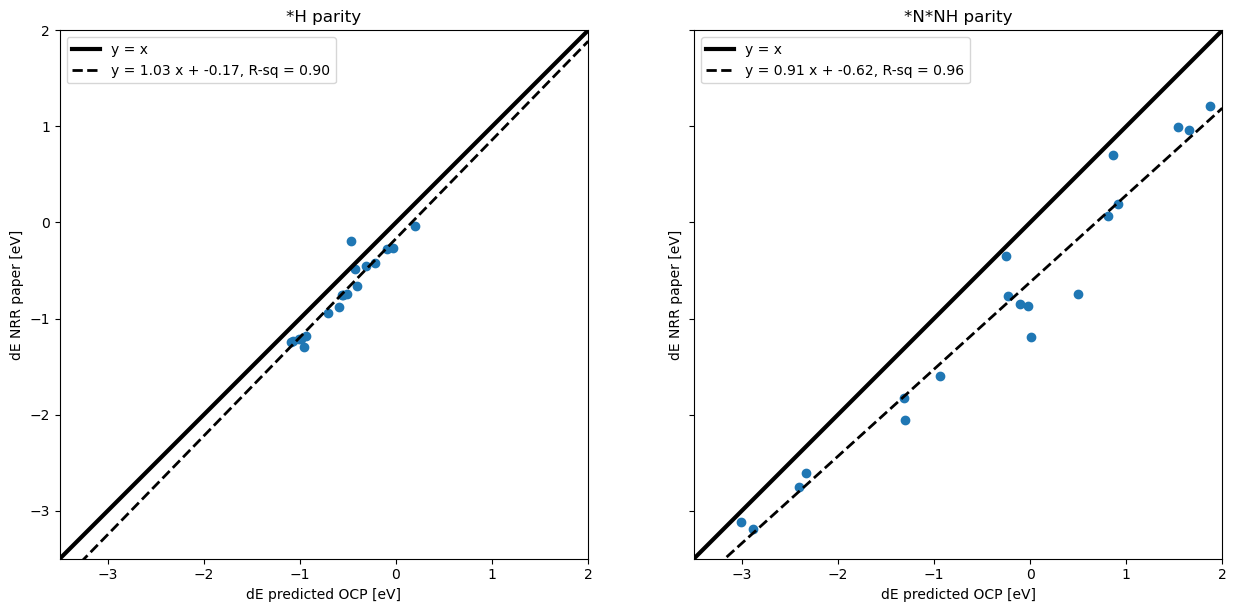

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(15)
x = df_all.min_E_ml_x.tolist()
y = df_all.E_lit_H.tolist()
ax1.set_title("*H parity")
ax1.plot([-3.5, 2], [-3.5, 2], "k-", linewidth=3)
slope, intercept, r, p, se = linregress(x, y)
ax1.plot(
    [-3.5, 2],
    [
        -3.5 * slope + intercept,
        2 * slope + intercept,
    ],
    "k--",
    linewidth=2,
)

ax1.legend(
    [
        "y = x",
        f"y = {slope:1.2f} x + {intercept:1.2f}, R-sq = {r**2:1.2f}",
    ],
    loc="upper left",
)
ax1.scatter(x, y)
ax1.axis("square")
ax1.set_xlim([-3.5, 2])
ax1.set_ylim([-3.5, 2])
ax1.set_xlabel("dE predicted OCP [eV]")
ax1.set_ylabel("dE NRR paper [eV]");


x = df_all.min_E_ml_y.tolist()
y = df_all.E_lit_NNH.tolist()
ax2.set_title("*N*NH parity")
ax2.plot([-3.5, 2], [-3.5, 2], "k-", linewidth=3)
slope, intercept, r, p, se = linregress(x, y)
ax2.plot(
    [-3.5, 2],
    [
        -3.5 * slope + intercept,
        2 * slope + intercept,
    ],
    "k--",
    linewidth=2,
)

ax2.legend(
    [
        "y = x",
        f"y = {slope:1.2f} x + {intercept:1.2f}, R-sq = {r**2:1.2f}",
    ],
    loc="upper left",
)
ax2.scatter(x, y)
ax2.axis("square")
ax2.set_xlim([-3.5, 2])
ax2.set_ylim([-3.5, 2])
ax2.set_xlabel("dE predicted OCP [eV]")
ax2.set_ylabel("dE NRR paper [eV]");
f.set_figwidth(15)
f.set_figheight(7)

# Make figure 6b and compare to literature results

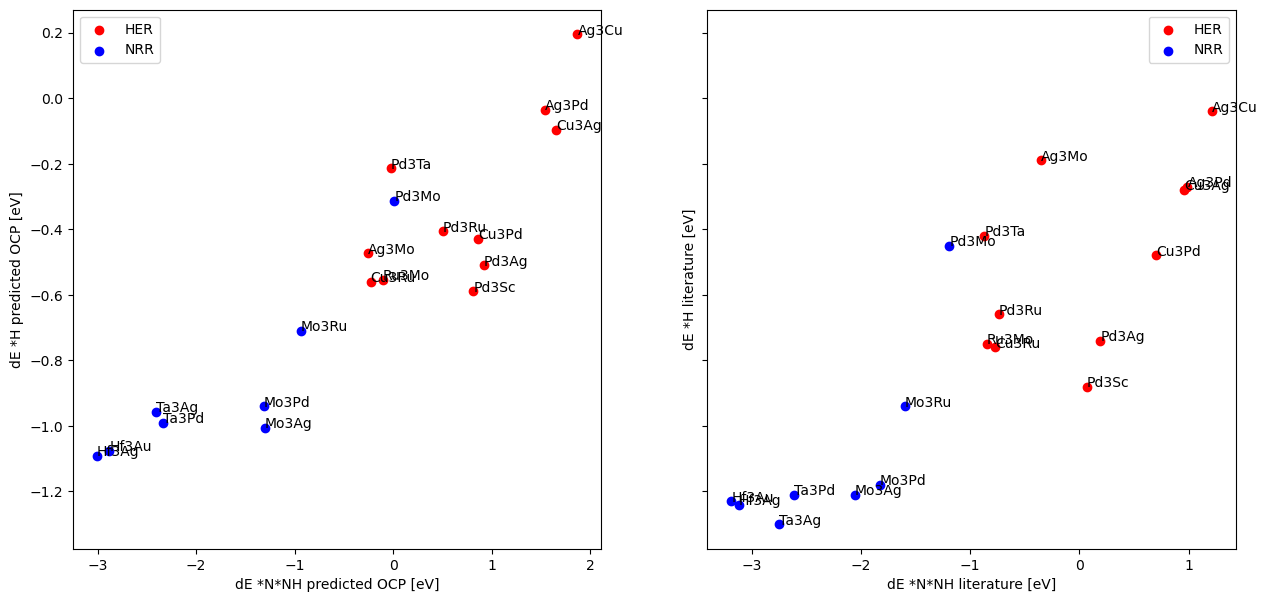

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
x = df_all[df_all.reaction == "HER"].min_E_ml_y.tolist()
y = df_all[df_all.reaction == "HER"].min_E_ml_x.tolist()
comp = df_all[df_all.reaction == "HER"].composition.tolist()

ax1.scatter(x, y,c= "r", label = "HER")
for i, txt in enumerate(comp):
    ax1.annotate(txt, (x[i], y[i]))

x = df_all[df_all.reaction == "NRR"].min_E_ml_y.tolist()
y = df_all[df_all.reaction == "NRR"].min_E_ml_x.tolist()
comp = df_all[df_all.reaction == "NRR"].composition.tolist()
ax1.scatter(x, y,c= "b", label = "NRR")
for i, txt in enumerate(comp):
    ax1.annotate(txt, (x[i], y[i]))


ax1.legend()
ax1.set_xlabel("dE *N*NH predicted OCP [eV]")
ax1.set_ylabel("dE *H predicted OCP [eV]")


x = df_all[df_all.reaction == "HER"].E_lit_NNH.tolist()
y = df_all[df_all.reaction == "HER"].E_lit_H.tolist()
comp = df_all[df_all.reaction == "HER"].composition.tolist()

ax2.scatter(x, y,c= "r", label = "HER")
for i, txt in enumerate(comp):
    ax2.annotate(txt, (x[i], y[i]))

x = df_all[df_all.reaction == "NRR"].E_lit_NNH.tolist()
y = df_all[df_all.reaction == "NRR"].E_lit_H.tolist()
comp = df_all[df_all.reaction == "NRR"].composition.tolist()
ax2.scatter(x, y,c= "b", label = "NRR")
for i, txt in enumerate(comp):
    ax2.annotate(txt, (x[i], y[i]))

ax2.legend()
ax2.set_xlabel("dE *N*NH literature [eV]")
ax2.set_ylabel("dE *H literature [eV]")
f.set_figwidth(15)
f.set_figheight(7)